# Preprocessing

In [60]:
# import libraries
import pandas as pd
import numpy as np 
import datetime as dt
import math

from sklearn.preprocessing import MinMaxScaler

# Visualization 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash import Dash, dcc, html, dash_table
from dash.dependencies import Input, Output, State
import ipywidgets as widgets
from IPython.display import clear_output


In [127]:
# Import raw data
rawdf = pd.read_csv('APAC Data Analytics Case Study.csv')
rawdf.head()

,Unnamed: 0,pspreference,currencycode,issuercountrycode,bin,creationdate,genericresponse,amount,scheme,merchant,company,acquireraccount,acquirer,journaltype,paymentmethod,approved,refused,received,threedattempt
0,1,psp:89068059460259968,IDR,ID,552695,2017-10-01 18:58:11,APPROVED,1000.0,mastercard,ABC_IDR,ABCLimited,AdyenMasterCardMalaysia_ABC_IDR,AdyenMasterCardMalaysia,Cancelled,commercialcredit,1,0,1,Yes
1,2,psp:67025064257904888,IDR,ID,547582,2017-10-01 12:47:47,APPROVED,1000.0,mastercard,ABC_IDR,ABCLimited,AdyenMasterCardMalaysia_ABC_IDR,AdyenMasterCardMalaysia,Cancelled,commercialcredit,1,0,1,Yes
2,3,psp:61362098320387304,IDR,ID,547582,2017-10-01 22:44:06,NOT_3D_AUTHENTICATED,1000.0,mastercard,ABC_IDR,ABCLimited,AdyenMasterCardMalaysia_ABC_IDR,AdyenMasterCardMalaysia,Refused,commercialcredit,0,1,1,Yes
3,4,psp:78486269968561824,IDR,ID,547582,2017-10-01 22:41:30,NOT_3D_AUTHENTICATED,1000.0,mastercard,ABC_IDR,ABCLimited,AdyenMasterCardMalaysia_ABC_IDR,AdyenMasterCardMalaysia,Refused,commercialcredit,0,1,1,Yes
4,5,psp:6116164638660848,IDR,KR,558420,2017-10-01 21:56:04,NOT_3D_AUTHENTICATED,1000.0,mastercard,ABC_IDR,ABCLimited,AdyenMasterCardMalaysia_ABC_IDR,AdyenMasterCardMalaysia,Refused,commercialcredit,0,1,1,Yes


In [3]:
for col in rawdf:
    print(col)
    print(rawdf[col].unique())
    print(len(rawdf[col].unique()))
    print('----------------------------------------')
    
# assume all merchants have no relation to each other, therefore cant cross compare across merchants in the market / conduct market analysis 

pspreference
['psp:89068059460259968' 'psp:67025064257904888' 'psp:61362098320387304'
 ... 'psp:20574157754890620' 'psp:73109800834208720'
 'psp:1238853996619582']
226868
----------------------------------------
currencycode
['IDR' 'MYR' 'SGD' 'THB']
4
----------------------------------------
issuercountrycode
['ID' 'KR' 'IN' 'US' nan 'NL' 'GB' 'MY' 'DE' 'HK' 'SG' 'FR' 'VN' 'TW' 'CN'
 'HU' 'CA' 'CL' 'BR' 'AU' 'CZ' 'PH' 'MX' 'RU' 'ES' 'LB' 'AR' 'SA' 'SI'
 'ZA' 'JP' 'TR' 'EG' 'TH' 'AE' 'LK' 'NO' 'CO' 'PK' 'BN' 'KE' 'SE' 'QA'
 'KW' 'NZ' 'AT' 'SR' 'IT' 'CH' 'KH' 'MO' 'BE' 'PL' 'DK' 'IE' 'BY' 'CR'
 'NG' 'EE' 'FI' 'PE' 'IL' 'LV' 'UA' 'BG' 'EC' 'KZ' 'PR' 'SO' 'BZ' 'TC'
 'PA' 'LT' 'OM' 'PT' 'JO' 'MM' 'BD' 'DO' 'RS' 'RO' 'HR' 'AM' 'LU' 'UY'
 'FJ' 'SK' 'MT' 'BB' 'HN' 'GI' 'PY' 'JM' 'SV' 'ZM' 'MU' 'BM' 'AF' 'MV'
 'TJ' 'IS' 'SM' 'MN' 'LA' 'AD' 'TT' 'VE' 'BH' 'GT' 'KG' 'GR' 'UZ' 'AG'
 'TZ' 'BA' 'CY' 'KM' 'GE']
118
----------------------------------------
bin
[552695 547582 558420 ... 557722 420003 

## Data Cleaning

In [380]:
df = rawdf.copy() 
df = df.drop(['Unnamed: 0', 'received'], axis=1)

df['issuercountrycode'] = np.where(df['issuercountrycode'].isna(), 'unspecified', df['issuercountrycode'])

## Feature Engineering

In [381]:
# Combine approve and refused columns into a boolean field
df['is_approved'] = np.where(df['approved'] ==1, 1, 0) # 1= approved, 0 = refused

# Identify FRAUD transactions (boolean field)
df['is_fraud'] = np.where(df['genericresponse'] == 'FRAUD', 1, 0)

# Change threedattempt into boolean field
df['threedattempt'] = np.where(df['threedattempt'] == 'Yes', 1, 0) #1= Ready to support native 3D Secure 2 authentication

# Time & Day
df['date_time'] = pd.to_datetime(df['creationdate'])
df['date'] = df['date_time'].dt.date
df['day'] = df['date_time'].dt.day_name()
df['weektype'] = np.where(df['day'].isin(['Saturday', 'Sunday']), 'weekend', 'weekday')

df['hour'] = df['date_time'].dt.hour
df['timeofday'] = np.where(df['hour'].isin(np.arange(6, 12)), 'day', 
                          np.where(df['hour'].isin(np.arange(12, 18)), 'afternoon', 
                          np.where(df['hour'].isin(np.arange(18, 24)), 'night', 
                          np.where(df['hour'].isin(np.arange(0, 6)), 'latenight', 
                          'unspecified'))))

# Transaction type: shopper type
df['domestic_shopper'] = np.where(df['currencycode'].str[:2] == df['issuercountrycode'], 1, 0)

In [382]:
# Payment method by card type
normal = ['credit', 'debit', 'standardcredit', 'standarddebit']
premium = ['premiumcredit', 'premiumdebit', 'superpremiumcredit', 'superpremiumdebit']
commercial = ['commercialcredit', 'commercialdebit', 'commercialpremiumcredit', 'commercialpremiumdebit', 'commercialsuperpremiumcredit']
corporate = ['corporatecredit', 'corporatedebit', 'fleetcredit', 'purchasingcredit', 'proprietary']

df['cardtype'] = np.where(df['paymentmethod'].isin(normal), 'normal', 
                          np.where(df['paymentmethod'].isin(premium), 'premium', 
                          np.where(df['paymentmethod'].isin(commercial), 'commercial', 
                          np.where(df['paymentmethod'].isin(corporate), 'corporate', 
                          'unspecified'))))

# Payment method by payment card
df['debit_credit'] = np.where(df['paymentmethod'].str.contains('credit'), 'credit', 
                          np.where(df['paymentmethod'].str.contains('debit'), 'debit',
                          'proprietary'))

In [383]:
# Categorize journal type
captured =['Authorised', 'SettledExternally', 'Settled', 'SentForSettle', 'SettledBulk']
tryagain =['Cancelled', 'Expired', 'CaptureFailed']
refunds =['RefundedExternally', 'Refunded', 'RefundFailed', 'SentForRefund']
refused =['Refused', 'Error'] # there are no refused journal type under genericersponse == Approved

df['journalcat'] = np.where(df['journaltype'].isin(captured), 'captured', 
                          np.where(df['journaltype'].isin(tryagain), 'tryagain', 
                          np.where(df['journaltype'].isin(refunds), 'refunds', 
                          np.where(df['journaltype'].isin(refused), 'refused', 
                          'unspecified'))))

Index(['IDR', 'MYR', 'SGD', 'THB'], dtype='object')


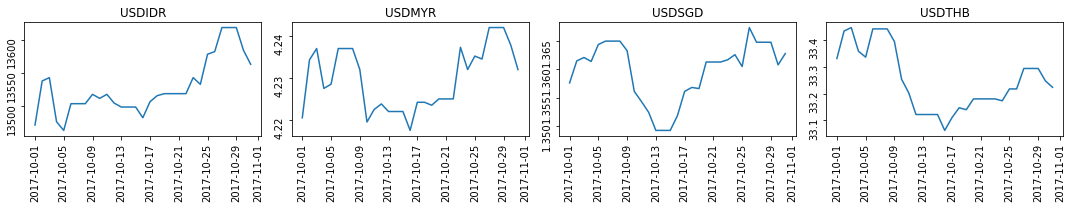

In [384]:
# Convert all amount to USD for standardization 

# Import fx rate data
fxdf = pd.read_csv('currency.csv')
fxdf['date'] = pd.to_datetime(fxdf['date'])

currencies = fxdf.columns[1:]
print(currencies)

fig, axs = plt.subplots(1, 4, figsize=(15, 3))
ind = 0
while ind < 4:
    axs[ind].plot(np.array(fxdf['date']) , np.array(fxdf[currencies[ind]]), label = currencies[ind])
    axs[ind].title.set_text('USD' +currencies[ind])
    axs[ind].tick_params(labelrotation=90)
    ind += 1
    
plt.tight_layout()
plt.show()

In [385]:
# Melt fx data 
fxdf_melt = pd.melt(fxdf, id_vars =['date'], value_vars = fxdf.columns[1:]).dropna()
fxdf_melt['date'] = fxdf_melt['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
fxdf_melt.columns = ['date_str', 'currencycode', 'fx_rate']

# Merge fx data into main df on date and currency
df['date_str'] = df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
df2 = pd.merge(df, fxdf_melt, how='left', on=['date_str', 'currencycode'])

# Get amount spent in standardized currency: USD
df2['amount_usd'] = df2['amount'] / df2['fx_rate']

,amount_bin,pspreference
0,micro,64290
1,small,69075
2,average,38947
3,large,54364
4,massive,192


<BarContainer object of 5 artists>

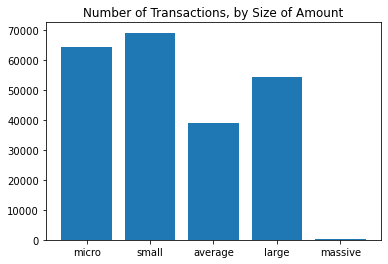

In [386]:
# Bin amount into sizes
df2['amount_bin'] =  pd.cut(df2['amount_usd'] , bins=[0.0, 1.0, 25, 500, 10000, 100000], 
                            labels= ['micro', 'small', 'average', 'large', 'massive']) # Ballparked bins based on 25%, 50% and 75%
t1 = df2.groupby(['amount_bin'])['pspreference'].count().reset_index()
display(t1)
plt.title('Number of Transactions, by Size of Amount')
plt.bar(t1.amount_bin.astype(str), t1.pspreference)

In [387]:
# Drop irrelevant columns
df2 = df2.drop(['amount', 'date_str', 'approved', 'refused', 'fx_rate', 'hour', 'creationdate'], axis =1) # fx rate is for standardization only, assume merchant does not bear any fx loss
df2.sample(5)

,pspreference,currencycode,issuercountrycode,bin,genericresponse,scheme,merchant,company,acquireraccount,acquirer,...,date,day,weektype,timeofday,domestic_shopper,cardtype,debit_credit,journalcat,amount_usd,amount_bin
91735,psp:28523170063272120,IDR,ID,524169,APPROVED,mastercard,XYZ_IDR,XYZLimited,AdyenMasterCardMalaysia_XYZ_IDR,AdyenMasterCardMalaysia,...,2017-10-13,Friday,weekday,day,1,normal,credit,captured,0.518557,micro
106045,psp:52301585371606048,IDR,ID,466160,APPROVED,visa,XYZ_IDR,XYZLimited,AdyenVisaMalaysia_XYZ_IDR,AdyenVisaMalaysia,...,2017-10-15,Sunday,weekend,day,1,normal,debit,captured,0.592636,micro
54399,psp:56005807872861624,SGD,SG,452419,FRAUD,visa,DEF_SGD,DEFLimited,RefusedRiskAcquirerAccount,RefusedAcquirer,...,2017-10-08,Sunday,weekend,day,1,premium,credit,refused,3663.003663,large
200012,psp:50099505623802544,MYR,MY,428332,APPROVED,visa,ABC_MYR,ABCLimited,AdyenVisaMalaysia_ABC_MYR,AdyenVisaMalaysia,...,2017-10-28,Saturday,weekend,afternoon,1,normal,debit,tryagain,23.573786,small
135300,psp:57395364390686152,IDR,ID,524325,APPROVED,mastercard,XYZ_IDR,XYZLimited,AdyenMasterCardMalaysia_XYZ_IDR,AdyenMasterCardMalaysia,...,2017-10-19,Thursday,weekday,afternoon,1,normal,credit,captured,3.254679,small


# EDA

## Descriptive Summary

In [388]:
# Lists
companies = np.unique(df2.company)
dates = np.unique(df2.date)
days = np.unique(df2.day)
cards = np.unique(df2.cardtype)
schemes = np.unique(df2.scheme)
journals = list(np.unique(df2.journalcat)) + ['All']

# List of fields available to filter on
fieldtypes = [elem for elem in df2.columns if elem not in ['pspreference', 'bin', 'company', 'amount_usd', 'date_time', 'date']]
fieldtypes = sorted(fieldtypes)

# Summary statistics
df2.describe()
# df2.loc[:, ~df2.columns.isin(['pspreference', 'creationdate', 'amount'])].apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1).style.background_gradient(cmap='coolwarm')

,bin,threedattempt,is_approved,is_fraud,domestic_shopper,amount_usd
count,226868.000000,226868.000000,226868.000000,226868.000000,226868.000000,226868.000000
mean,491153.083432,0.429999,0.882275,0.080170,0.861408,531.510847
std,50233.273537,0.495077,0.322283,0.271557,0.345521,1292.215587
min,400000.000000,0.000000,0.000000,0.000000,0.000000,0.036716
25%,450824.000000,0.000000,1.000000,0.000000,1.000000,0.665779
50%,498001.000000,0.000000,1.000000,0.000000,1.000000,23.615539
75%,540912.000000,1.000000,1.000000,0.000000,1.000000,444.005929
max,591882.000000,1.000000,1.000000,1.000000,1.000000,73364.177132


<ipython-input-389-36ff1664efd4>:3: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



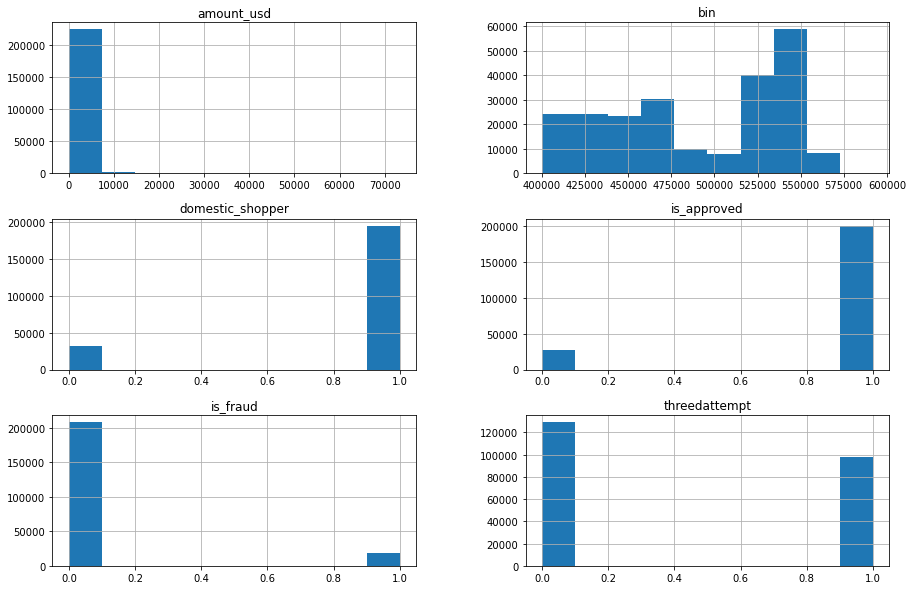

In [389]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
df2.hist(ax = ax);

## Transaction flow (sankey)

In [390]:
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 cat cols -> 6 colors
    colorPalette = ['#4B8BBE','#309871','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
#         labelList = [str(i) for i in labelList]
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = go.Figure(data= dict(data=[data], layout=layout))
    return fig


# # Test
# company_dd = 'ABCLimited' 
# field1_dd = 'is_approved'
# field2_dd = 'merchant'
# field3_dd = 'journaltype'

# df_view = df2[df2['company'] == company_dd]
# fig = genSankey(df_view, cat_cols = [field1_dd, field2_dd, field3_dd], 
#             value_cols='amount_usd', title=f'TPV flow of {company_dd}')
# fig.show()

In [391]:
# Plot Sankey

# Initiale df filter
company_dd = 'ABCLimited' 
field1_dd = 'threedattempt'
field2_dd = 'merchant'
field3_dd = 'journaltype'

df_view = df2[df2['company'] == company_dd]

# Widgets
company_dd = widgets.Dropdown(options= companies, value= companies[0], description='Select Company',
                              style= {'description_width': 'initial'})
field1_dd = widgets.Dropdown(options= fieldtypes, value= 'threedattempt', description='Select Field 1',
                              style= {'description_width': 'initial'})
field2_dd = widgets.Dropdown(options= fieldtypes, value= 'merchant', description='Select Field 2',
                              style= {'description_width': 'initial'})
field3_dd = widgets.Dropdown(options= fieldtypes, value= 'journaltype', description='Select Field 3',
                              style= {'description_width': 'initial'})

def callback(__):
    clear_output(wait=True)
    main_box.children = [setup_ui, button_run]
    display(main_box)
    
    # Get Dataframe and plot
    df_view = df2[df2['company'] == company_dd.value]
    txn_flow = genSankey(df_view, cat_cols = [field1_dd.value, field2_dd.value, field3_dd.value], 
                        value_cols='amount_usd', title=f'TPV flow of {company_dd.value}')
    
    return txn_flow.show()

# Show
setup_ui = widgets.VBox([company_dd, field1_dd, field2_dd, field3_dd])
display(setup_ui)

button_run = widgets.Button(description='Run')
main_box = widgets.VBox([button_run])
button_run.on_click(callback)

display(main_box)

## Merchant Performance Overview

In [392]:
def plot_merchant_overview(df, company_dd, field_dd, target_dd):
    df_comp = df[df['company'] == company_dd]
    if target_dd != 'All':
        df_comp = df_comp[df_comp['journalcat'] == target_dd]

    overview_df = df_comp.groupby('date')['amount_usd'].mean().reset_index()
    field_df = df_comp.groupby(field_dd)['amount_usd'].mean().reset_index()

    # Time series
    fig = make_subplots(rows=2, cols=2,specs=[[{}, {'type':'domain'}], [{}, {}]],
                            subplot_titles=['Avg Revenue Across Time',
                                            f'Revenue Distribution by {field_dd}',
                                           'Intraday Revenue', 'Daily Revenue'])

    fig.add_trace(go.Scatter(x=overview_df['date'], y=overview_df['amount_usd']), row=1, col=1)
    fig.add_trace(go.Pie(labels=field_df[field_dd], values=field_df['amount_usd']),row=1, col=2)

    for merc in np.unique(df_comp[field_dd]):
        temp_df = df_comp[df_comp[field_dd] == merc].groupby(['timeofday'])['amount_usd'].mean().reset_index()
        fig.add_trace(go.Bar(x=temp_df['timeofday'],
                             y=temp_df['amount_usd'], 
                             name = str(merc)),
                                row=2, col=1)
        fig.update_xaxes(categoryorder='array', categoryarray= ['day','afternoon','night','latenight'], row=2, col=1)

        temp_df = df_comp[df_comp[field_dd] == merc].groupby(['day'])['amount_usd'].mean().reset_index()
        fig.add_trace(go.Bar(x=temp_df['day'],
                             y=temp_df['amount_usd'], 
                             name = str(merc)),
                            row=2, col=2)
        fig.update_xaxes(categoryorder='array', categoryarray= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
                         , row=2, col=2)


    fig.update_layout(barmode='relative', title_text= f"{company_dd} for {target_dd} Transactions", showlegend=False)
    return fig

## To Test
# company_dd = companies[2]
# field_dd = fieldtypes[-2]
# target_dd = journals[3]
# plot_merchant_overview(df2, company_dd, field_dd, target_dd)

In [393]:
# TODO: Switch between TPV and Volume 

# Initiate filters
company_dd = companies[2]
field_dd = fieldtypes[-2]
target_dd = journals[3]

df_comp = df2[df2['company'] == company_dd]

# Widgets
company_dd = widgets.Dropdown(options= companies, value= companies[0], description='Select Company',
                              style= {'description_width': 'initial'})
field_dd = widgets.Dropdown(options= fieldtypes, value= fieldtypes[3], description='Select Field for Revenue Breakdown',
                              style= {'description_width': 'max-content'},
                           layout= {'width': 'max-content'})
target_dd = widgets.Dropdown(options= journals, value= 'All', description='Select Target Transaction status',
                              style= {'description_width': 'initial'})

def callback(__):
    clear_output(wait=True)
    main_box.children = [setup_ui, button_run]
    display(main_box)
    
    fig = plot_merchant_overview(df2, company_dd.value, field_dd.value, target_dd.value)
    return fig.show()

# Show
setup_ui = widgets.VBox([company_dd, field_dd, target_dd])
display(setup_ui)

button_run = widgets.Button(description='Run')
main_box = widgets.VBox([button_run])
button_run.on_click(callback)

display(main_box)

# Analysis

## Fraud Analysis

In [394]:
company_dd = companies[0]
fraud_df = df2[df2['company'] == company_dd]


fraud_stat= fraud_df.groupby(['is_fraud']).agg({'pspreference':'nunique',
                                   'bin': 'nunique',
                                   'amount_usd': 'mean'}).reset_index()
display(fraud_stat)

print(f'{fraud_stat.loc[1,"pspreference"]/(fraud_stat.loc[1,"pspreference"]+fraud_stat.loc[0,"pspreference"]) *100: .2f}% of transactions are fraud for {company_dd}')
print(f'{fraud_stat.loc[1,"bin"]/(fraud_stat.loc[1,"bin"]+fraud_stat.loc[0,"bin"]) *100: .2f}% of cards are fraud for {company_dd}')

if fraud_stat.loc[1,"amount_usd"] < fraud_stat.loc[0,"amount_usd"]:
    print(f'The average fraud transaction is smaller than non-fraud transaction.')
else:
    print(f'The average fraud transaction is larger than non-fraud transaction.')

,is_fraud,pspreference,bin,amount_usd
0,0,90143,2436,493.945389
1,1,10509,925,546.956912


 10.44% of transactions are fraud for ABCLimited
 27.52% of cards are fraud for ABCLimited
The average fraud transaction is larger than non-fraud transaction.


In [427]:
company_dd = companies[2]
field_dd = 'threedattempt' #fieldtypes[3]

fraud_df = df2[df2['company'] == company_dd]
temp_df = fraud_df.groupby(['is_fraud', field_dd])['amount_usd'].mean().reset_index()

fig = make_subplots(rows=1, cols=1, subplot_titles= (''))

for i,f in zip([0,1], ['Not Fraud', 'Fraud']):
    temp_df2 = temp_df[temp_df['is_fraud'] == i]
    fig.add_trace(go.Bar(x=temp_df2[field_dd], y=temp_df2['amount_usd'], name = f), row=1, col=1)
                    
fig.update_layout(barmode='group', title_text=f'{company_dd} Avg amount, by {field_dd}', showlegend=True)
fig.show()

# threedattempt == 1 has 0 fraud

# ML

### DT: Fraud or not fraud?

In [409]:
from sklearn import tree, model_selection, metrics
from pandas.api.types import CategoricalDtype 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


In [428]:
company_dd = companies[0]

# Drop irrelevant columns 
fraud_ml = df2[df2['company'] == company_dd].drop(['pspreference', 'company', 'bin', 'date_time', 'date', 'is_approved', 'genericresponse', 'threedattempt', 'journalcat', 'journaltype', 'acquirer', 'acquireraccount'], axis=1)

# Split dataset
X = fraud_ml.drop('is_fraud', axis=1)
y = fraud_ml['is_fraud']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=2019)

In [430]:
# One Hot Encoding with training set only
OHE_df = pd.DataFrame()
categorical_cols = ['currencycode', 'issuercountrycode', 'scheme', 'merchant', 'paymentmethod', 
                    'day', 'weektype', 'timeofday', 'cardtype', 'debit_credit', 'amount_bin']

for i in categorical_cols:
    OHE_df[i] = X_train[i].astype(CategoricalDtype(list(set(X[i]))))
    OHE_df = pd.concat([OHE_df, pd.get_dummies(X[i], prefix=i)],axis=1)
    
    
OHE_df = OHE_df.drop(categorical_cols, axis= 1) # remove original categorical columns, keep OHE columns only
X_no_cat = X.drop(categorical_cols, axis= 1) # Get numerical column
OHE_df = pd.concat([X_no_cat, OHE_df],axis=1) # concat numeric and OHE columns into OHE_df

In [433]:
# Resplit X dataset with OHE columns
OHE_train, OHE_test, y_train, y_test = model_selection.train_test_split(OHE_df, y, test_size=0.2, random_state=2019)

print('Before OHE, n features = ', X_train.shape[1])
print('After OHE, n features = ', OHE_train.shape[1])

Before OHE, n features =  13
After OHE, n features =  159


In [434]:
# Build Model
dt_estimator = tree.DecisionTreeClassifier(random_state=40)

In [435]:
# Base Model
dt_estimator.fit(OHE_train, y_train)

# Evaluation
y_predict_train = dt_estimator.predict(OHE_train)
print('Training Accuracy: ', accuracy_score(y_train, y_predict_train))

y_predict = dt_estimator.predict(OHE_test)
print('Test Accuracy: ', accuracy_score(y_test, y_predict))

# Feature Importance 
important_features_dict = {}
for idx, val in enumerate(dt_estimator.feature_importances_):
    important_features_dict[idx] = val

top_idx = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)[:10]

top_features_names = OHE_train.columns[top_idx]
top_features_scores = dt_estimator.feature_importances_[top_idx]
print('\nTop 5 most important features: \n')
for i in range(5):
    print('%s: %s, Score: %.3f ' % (i+1, top_features_names[i], top_features_scores[i]))

Training Accuracy:  0.938587449236845
Test Accuracy:  0.9065620187770106

Top 5 most important features: 

1: amount_usd, Score: 0.403 
2: debit_credit_debit, Score: 0.068 
3: issuercountrycode_ID, Score: 0.067 
4: scheme_visa, Score: 0.054 
5: timeofday_night, Score: 0.026 


In [ ]:
# GridSearch
criterions = ['entropy', 'gini']
max_depth = [5,6]
min_samples_split = [2,5,10]
min_samples_leaf = [3,4,5,6]

param_grid = {'criterion': criterions, 
              'max_depth': max_depth, 
              'min_samples_split': min_samples_split, 
              'min_samples_leaf': min_samples_leaf}

grid_dt_class = GridSearchCV(estimator = dt_estimator, param_grid = param_grid, 
                             scoring='accuracy', n_jobs=-1, cv = 10, 
                             refit=True, return_train_score=True, verbose=10)

grid_dt_class.fit(OHE_df, y)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

In [ ]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='cv')
        ax[i].set_xlabel(p.upper())

    plt.legend(loc = 'lower right')
    plt.show()
    
plot_search_results(grid_dt_class)

In [ ]:
# Evaluation
print(grid_dt_class.best_params_)
print("Model best score: ", grid_dt_class.best_score_)

In [ ]:
# Build Tuned Model
dtree = DecisionTreeClassifier(criterion= 'entropy', max_depth= 6,
                               min_samples_leaf= 10,
                               min_samples_split= 5, random_state = 40
                              )
dtree.fit(OHE_train, y_train)
y_predict = dtree.predict(OHE_test)

report = """
The evaluation report is:
Confusion Matrix:
{}
Accuracy: {}
""".format(confusion_matrix(y_test, y_predict),
           accuracy_score(y_test, y_predict))
print(report)

In [ ]:
feature_list = list(OHE_train.columns)
cn = ['fail', 'success']

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(dtree,
               feature_names = feature_list, 
               class_names = cn,
               filled = True)
fig.savefig('dtree.png')

In [ ]:
# Retrieve Feature Importance
important_features_dict = {}
for idx, val in enumerate(dtree.feature_importances_):
    important_features_dict[idx] = val

top_idx = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)[:10]

top_features_names = OHE_train.columns[top_idx]
top_features_scores = dtree.feature_importances_[top_idx]

print('Top 3 most important features: \n')

for i in range(3):
    print('%s: %s, Score: %.3f ' % (i+1, top_features_names[i], top_features_scores[i]))